In [225]:
#Authors: Adam Lewandowski, Ivan Sladkov, Patrick English
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import nltk
from sklearn.utils import shuffle
import matplotlib
import matplotlib.pyplot as plt
# random seeds
seed=2020
np.random.seed(seed)
tf.random.set_seed(seed)

In [226]:
def str_list_to_list(tweets):
    t = tweets.copy()
    import ast 
    t["tweets"] = t["tweets"].apply(lambda x: ast.literal_eval(x))
    return t
#Download this: https://drive.google.com/open?id=1-3lesjyVd1gGnjJGz_cipqO8CNeiTiPx
#Put it into data folder
tweets = pd.read_csv("data/processed_tweets.csv", encoding = "ISO-8859-1")
tweets = str_list_to_list(tweets)

In [227]:
def parse_tweet(tweet, word_dictionary):
    sentence = []
    for word in tweet:
        try:
            if word[0]=='@':
                sentence.append(word_dictionary['<usr>'])
            else:
                sentence.append(word_dictionary[word])
        except KeyError:
            sentence.append(1)
    return sentence

In [228]:
def prepare_input_data(df, dictionary_size):
    # Pre-processing for word embeddings
    # Count each unique word
    raw_words = df['tweets']
    word_count = {}
    for tweet in raw_words:
        for word in tweet:
            if word[0]!='@':
                if word in word_count:
                    word_count[word] += 1
                else:
                    word_count[word] = 1
    # Sort each unique word using the value
    sorted_word_count = sorted(word_count.items(), key=lambda key: key[1], reverse=True)
    
    # create dictionaries to convert tokens to integers and integers to tokens (needed for the embedding layer)
    # <pad> will be used for padding the data because the NN inputs have to be the same size and tweets are of varying length
    # <unk> will be used to replace tokens that were too uncommon to add to the dictionary
    word_dictionary={'<pad>': 0, '<unk>': 1, '<usr>': 2}
    for i in range(dictionary_size):
        word_dictionary[sorted_word_count[i][0]]=i+3
    reverse_dictionary = dict([(value, key) for (key, value) in word_dictionary.items()])

    # Convert each token into its index in the dictionary and
    # create a new dataframe with the list of indexes and corresponding targets
    data=[]
    
    for tweet in df['tweets']:
        data.append(parse_tweet(tweet, word_dictionary))

    input_data=pd.DataFrame({
        'data': data,
        'targets': df['target']
    })
    
    return input_data, word_dictionary, reverse_dictionary, word_count

In [229]:
def split_padded_data(data, seed, tweet_length=None, sample_size=None):
    if tweet_length == None:
        # Get the length of the longest tweet
        max_tweet_length=len(max(data['data'], key=len))
    else:
        max_tweet_length=tweet_length
    # Split the data 80% train data (later a subset will be selected as validation data) - 20% test data
    shuffled_dataframe=shuffle(data, random_state=seed)
    if sample_size != None:
        shuffled_dataframe=shuffled_dataframe[:sample_size]
    train_dataframe=shuffled_dataframe.sample(frac=0.8, random_state=seed)
    test_dataframe=shuffled_dataframe.drop(train_dataframe.index)
    
    # Pad the tweets with <pad> up to the max tweet length so all tweets have the same length
    train_data=keras.preprocessing.sequence.pad_sequences(list(train_dataframe['data']),
                                                        value=0,
                                                        padding='post',
                                                        maxlen=max_tweet_length)
    train_targets=train_dataframe['targets'].replace(4,1)
    
    test_data=keras.preprocessing.sequence.pad_sequences(list(test_dataframe['data']),
                                                        value=0,
                                                        padding='post',
                                                        maxlen=max_tweet_length)
    test_targets=test_dataframe['targets'].replace(4,1)
    
    return train_data, train_targets, test_data, test_targets, max_tweet_length
    

In [257]:
def create_model(train_data, train_targets, word_dictionary, max_tweet_length, seed):
    model = keras.models.Sequential()
    model.add(keras.layers.Embedding(len(word_dictionary), output_dim=150, input_length=max_tweet_length, trainable=True, embeddings_initializer=keras.initializers.RandomUniform(seed=None)))
    #model.add(keras.layers.Conv1D(100, 4, activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
    #model.add(keras.layers.MaxPool1D(2))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(80, kernel_initializer=keras.initializers.glorot_uniform(seed=seed),recurrent_initializer=keras.initializers.orthogonal(seed=seed), return_sequences=True)))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(32, kernel_initializer=keras.initializers.glorot_uniform(seed=seed),recurrent_initializer=keras.initializers.orthogonal(seed=seed))))

    #model.add(keras.layers.LSTM(100, kernel_initializer=keras.initializers.glorot_uniform(seed=seed),recurrent_initializer=keras.initializers.orthogonal(seed=seed)))
    #model.add(keras.layers.Dense(32, activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
    model.add(keras.layers.Dropout(0.2, seed=seed))
    model.add(keras.layers.Dense(1, activation='sigmoid', kernel_initializer=keras.initializers.glorot_uniform(seed=seed)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model

In [232]:
# Some variables used for pre-processing the data
dictionary_size=25000

In [249]:
# Pre-process the data.
# Create the dictionaries
input_data, word_dictionary, reverse_dictionary, word_count = prepare_input_data(tweets, dictionary_size)

In [250]:
#split and pad the data
train_data, train_targets, test_data, test_targets, max_tweet_length = split_padded_data(input_data, seed, 26)

In [251]:
len(train_data)

1280000

In [170]:
lengths = [len(x) for x in input_data['data']]

In [171]:
unique_lengths = set(lengths)

In [172]:
length_occurrence = []
for i in unique_lengths:
    length_occurrence.append(lengths.count(i))

<BarContainer object of 40 artists>

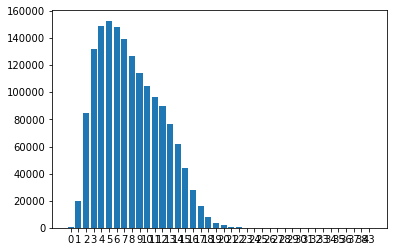

In [173]:
plt.bar([str(i) for i in unique_lengths], length_occurrence)

In [174]:
x=zip(unique_lengths,length_occurrence)
for i in tuple(x):
    print(i)

(0, 316)
(1, 19443)
(2, 84547)
(3, 132075)
(4, 149166)
(5, 152892)
(6, 148587)
(7, 139592)
(8, 126578)
(9, 114069)
(10, 104509)
(11, 96804)
(12, 89724)
(13, 76647)
(14, 61538)
(15, 44309)
(16, 27820)
(17, 15756)
(18, 8159)
(19, 3810)
(20, 1835)
(21, 806)
(22, 431)
(23, 214)
(24, 108)
(25, 102)
(26, 36)
(27, 42)
(28, 20)
(29, 24)
(30, 12)
(31, 5)
(32, 7)
(33, 6)
(34, 3)
(35, 3)
(36, 1)
(37, 1)
(38, 1)
(43, 2)


In [258]:
model=create_model(train_data, train_targets, word_dictionary, max_tweet_length, seed)

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_42 (Embedding)     (None, 26, 150)           2250450   
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 26, 160)           147840    
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 64)                49408     
_________________________________________________________________
dropout_49 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 65        
Total params: 2,447,763
Trainable params: 2,447,763
Non-trainable params: 0
_________________________________________________________________
None


In [259]:
model.fit(train_data, train_targets, epochs=2,batch_size=20, verbose=1, validation_split=0.1)

Train on 1152000 samples, validate on 128000 samples
Epoch 1/2
1152000/1152000 [==============================] - 3124s 3ms/sample - loss: 0.4578 - accuracy: 0.7817 - val_loss: 0.4410 - val_accuracy: 0.7921
Epoch 2/2
1152000/1152000 [==============================] - 3152s 3ms/sample - loss: 0.4248 - accuracy: 0.8019 - val_loss: 0.4350 - val_accuracy: 0.7941


In [254]:
model.evaluate(test_data, test_targets, batch_size=50)

320000/320000 [==============================] - 97s 303us/sample - loss: 0.4381 - accuracy: 0.7942


[0.4381145809381269, 0.79423124]